In [72]:
DEBATE_URL = 'http://www.presidency.ucsb.edu/debates.php'
Q_DENSITY_CUTOFF = .0014
last_fetched_at = None
import json
import matplotlib.pyplot as plt
import urllib.request, time, re, random, hashlib
import bs4
import time
import sys
import nltk
import nltk.data
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.corpus import wordnet
from nltk import bigrams
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from scipy.spatial.distance import cosine
import pandas as pd
import numpy as np
from scipy.spatial import distance
import time
import copy
import math
PARTY_FILE = 'party_names.csv'
TEXT_FIELDS = ['full_text','compound_bgms'] # fields in final matrix that are manually added
%matplotlib inline

In [3]:
def fetch(url):
    """Load the url compassionately. Borrowed from HW1"""
    
    global last_fetched_at
    
    url_hash = hashlib.sha1(url.encode()).hexdigest()
    filename = 'cache/cache-file-{}'.format(url_hash)
    try:
        with open(filename, 'r') as f:
            result = f.read()
            if len(result) > 0:
                #print("Retrieving from cache:", url)
                return result
    except:
        pass
    
    #print("Loading:", url)
    wait_interval = random.randint(3000,10000)
    if last_fetched_at is not None:
        now = time.time()
        elapsed = now - last_fetched_at
        if elapsed < wait_interval:
            time.sleep((wait_interval - elapsed)/1000)
        
    user_agent = 'Mozilla/5.0 (Windows NT 6.1; Win64; x64)'
    headers = { 'User-Agent' : user_agent }
    req = urllib.request.Request(url, headers = headers)
    last_fetched_at = time.time()
    with urllib.request.urlopen(req) as response:
        result = str(response.read())
        with open(filename, 'w') as f:
            f.write(result)
    
        return result

In [4]:
# site is set up as a table, this extracts their information including a link
def debate_processing(soup):
    return_list = []
    tables = soup.find_all('table')
    
    for table in tables:
        if table['width'] == '700' and table['bgcolor'] == "#FFFFFF":
            actual_table = table
    rows = actual_table.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        
        cols = [x.text.strip() for x in cols]
        try:
            link = row.find('a')['href']
            cols.append(link)
            return_list.append(cols)
        except:
            pass

    return return_list

In [5]:
def get_words_from_speech(link):
    result = fetch(link)
    soup = bs4.BeautifulSoup(result,'lxml')
    return soup

In [6]:
def get_debate_dict():
    result = fetch(DEBATE_URL)
    soup = bs4.BeautifulSoup(result,'lxml')
    debate_list = debate_processing(soup)
    debate_dict = {}
    for debate in debate_list:

        if ' ' not in debate[0]:
            debate = debate[1:]
        debate_id = ' '.join(debate[:2])
        try:
            clean_time = debate[0].replace('th,',',').replace('st,',',').replace('rd,',',').replace('nd,',',')
            debate_datetime = time.strptime(clean_time,'%B %d, %Y')
            
        except:
            debate_datetime = None


        debate_dict[debate_id] = {}
        debate_dict[debate_id]['link'] = debate[2]
        debate_dict[debate_id]['time'] = debate_datetime 
        
        try:
            debate_dict[debate_id]['soup'] = get_words_from_speech(debate[2])
        except:
            debate_dict[debate_id]['soup'] = None
        
    return debate_dict

In [7]:
def find_politician_names(debate_dict):
    for key in debate_dict.keys():
        raw = get_soup_text(debate_dict[key])
        raw = raw.replace("--", ". ")
        sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
        sents = sent_detector.tokenize(raw.strip())

        #find candidate names, most commonly repeated first words of sentences, not common words
        colon_names = []
        period_names = []

        #get names from before colons
        for sent in sents:
            if ':' in sent:
                sent = sent.split(':')
                possible_name = sent[0] + ":"
                possible_name_no_paren = remove_paren(possible_name).strip()
                if (len(possible_name_no_paren)<25) & (len(possible_name_no_paren)>2):
                    colon_names.append(possible_name_no_paren)

        fdist1 = FreqDist(colon_names)
        fdist1_above_5 = [name[0] for name in fdist1.most_common(15) if name[1]>5]

        #get names before periods
        for sent in sents:
            if len(nltk.word_tokenize(sent))<5:
                possible_name = sent
                possible_name_no_paren = remove_paren(possible_name).strip()
                if (len(possible_name_no_paren)<25) & (len(possible_name_no_paren)>2):
                    period_names.append(possible_name_no_paren)

        fdist2 = FreqDist(period_names)
        fdist2_above_15 = [name[0] for name in fdist2.most_common(15) if name[1]>15 and "YES" not in name[0].upper() and "WRITE" not in name[0].upper()]

        #add names to dict
        colon_name_highest_freq = fdist1.most_common(1)[0][1]
        if colon_name_highest_freq > 20 :
            debate_dict[key]['names'] = fdist1_above_5
        else:
            debate_dict[key]['names'] = fdist2_above_15

    return debate_dict

In [8]:
def get_soup_text(dbt):
    # Prep for tokenization and sentence division
    raw = dbt['soup'].get_text()
    raw = raw.replace("\\", "")
    raw = raw.replace(".", ". ")
    raw = raw.replace("?", "? ")
    raw = raw.replace("!", "! ")
    raw = raw.replace("  ", " ")
    raw = raw.replace("-", "- ")
    raw = raw.replace("…", ". ")
    raw = raw.replace("...", ". ")
    return raw
    

In [9]:
def remove_paren(name):
    return_name = ''
    skip1c = 0
    skip2c = 0
    for i in name:
        if i == '[':
            skip1c += 1
        elif i == '(':
            skip2c += 1
        elif i == ']' and skip1c > 0:
            skip1c -= 1
        elif i == ')'and skip2c > 0:
            skip2c -= 1
        elif skip1c == 0 and skip2c == 0:
            return_name += i
    return return_name

In [10]:
def remove_non_politicians(cand_text_dict):
    '''
    Use question'''
    for year in cand_text_dict.keys():
        for cand in cand_text_dict[year].keys():
            cand_text_dict[year][cand]['q_density'] = 0
            text = cand_text_dict[year][cand]['full_text']
            num_chars = len(list(text))
            num_q_marks = text.count('?')
            if num_chars > 0:
                cand_text_dict[year][cand]['q_density'] = num_q_marks/num_chars

    cand_text_dict_no_mod = copy.deepcopy(cand_text_dict)
    #remove liekly moderators
    for year in cand_text_dict.keys():
        for cand in cand_text_dict[year].keys():
            if ((cand == 'MALE' and 'MALE' in cand_text_dict_no_mod[year]) or 
                (cand == 'UNKNOWN' and 'UNKNOWN' in cand_text_dict_no_mod[year]) or 
                (cand == 'WRITE' and 'WRITE' in cand_text_dict_no_mod[year]) or
                (cand =='GOV' and 'GOV' in cand_text_dict_no_mod[year])):
                del cand_text_dict_no_mod[year][cand]
    
            if (cand_text_dict[year][cand]['q_density'] > Q_DENSITY_CUTOFF):
                if (cand in cand_text_dict_no_mod[year]):
                    del cand_text_dict_no_mod[year][cand]

        
    return cand_text_dict_no_mod

In [11]:
 def clean_dirty_name_lookup(names):
    
    lookup_dict = {}
    
    for name in names:
        clean_name = name.split()[-1].upper().replace('.','').replace(')','').replace(';','').replace(':','')
        lookup_dict[name] = clean_name
    
    return lookup_dict

In [12]:
def get_election_year(year, dbt):
    year = dbt['time'].tm_year
    year_mod = year % 4
    if year_mod == 0:
        election_year = year
    else:
        election_year = year + (4 - year_mod)
    return election_year

In [13]:
def clean_names(debate_dict):
    # Add debate year
    name_years = {}
    for dbt in debate_dict.keys():
        time = debate_dict[dbt]['time']

        # Get election year
        if time:
            election_year = get_election_year(time.tm_year, debate_dict[dbt])
        else:
            election_year = 'dbt'
        debate_dict[dbt]['election_year'] = election_year

        # Add new set of names from debate to name_years dict
        if election_year not in name_years:
            name_years[election_year] = {'names':set()}

        names = set(debate_dict[dbt]["names"])
        name_years[election_year]['names'] = name_years[election_year]['names'].union(names)

    # Reduce all names in one year to a single name
    for year in name_years:
        name_years[year]['lookup'] = clean_dirty_name_lookup(name_years[year]['names'])

    # Add lookup dictionary to debate dictionary
    for dbt in debate_dict.keys():
        election_year = debate_dict[dbt]['election_year']
        debate_dict[dbt]['lookup'] = name_years[election_year]['lookup']
        debate_dict[dbt]['clean_names'] = debate_dict[dbt]['lookup'].values()
    
    return debate_dict

In [14]:
def attribute_text(debate_dict):
    #make year/candidate dictionary for text
    cand_text_dict = {}
    for dbt in debate_dict.keys():
        year = debate_dict[dbt]['election_year']
        cand_text_dict[year] = {}
        for cand in debate_dict[dbt]["clean_names"]:
            cand_text_dict[year][cand] = {}
            cand_text_dict[year][cand]['full_text'] = ""
    
    #fill year/candidate dictionary
    for dbt in debate_dict.keys():
        #set variables
        year = debate_dict[dbt]["election_year"]
        names = debate_dict[dbt]["names"]
        if "write" in names:
            names.remove('write')
        
        #get debate soup
        raw = get_soup_text(debate_dict[dbt])
        
        #tokenize sents
        for name in names:
            raw = raw.replace(name, ". " + name)
        sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
        sents = sent_detector.tokenize(raw.strip())
        
        #loop through sents
        current_speaker = ""
        got_first_speaker = False
        for sent in sents:
            new_speaker = (len([name for name in names if name in sent])>0)
            if(new_speaker):
                got_first_speaker = True
                current_speaker_dirty = [name for name in names if name in sent][0]
                current_speaker = debate_dict[dbt]["lookup"][current_speaker_dirty]
            
            if(got_first_speaker):
                sent_no_name = sent.replace(current_speaker_dirty, "")
                cand_text_dict[year][current_speaker]['full_text'] = (cand_text_dict[year][current_speaker]['full_text'] + " " + sent_no_name)
    
    #fix "president" as candidate name
    for year in cand_text_dict.keys():
        #loop through candidates
        if year == 2012:
            cand_text_dict[year]['OBAMA'] = cand_text_dict[year].pop('PRESIDENT')
        if year == 1996:
            cand_text_dict[year]['CLINTON'] = cand_text_dict[year].pop('PRESIDENT')
        if year == 1984:
            cand_text_dict[year]['REAGAN'] = cand_text_dict[year].pop('PRESIDENT')
        if year == 1980:
            cand_text_dict[year]['CARTER'] = cand_text_dict[year].pop('PRESIDENT')
        if year == 1976:
            cand_text_dict[year]['FORD'] = cand_text_dict[year].pop('PRESIDENT')
    return cand_text_dict

In [15]:
def similarity_model(cand_text_dict):
    dumbWords = stopwords.words('english')
    political_positions = ['Governor', 'Senator', 'President']
    
    
    #loop through election years
    for year in cand_text_dict.keys():
        #loop through candidates
        for cand in cand_text_dict[year].keys():
            #print(year, cand)
        
            tokens = nltk.word_tokenize(cand_text_dict[year][cand]['full_text'])
            text = nltk.Text(tokens)
            
            if len(text)>0:
                #avg word len
                sum_len = sum([len(word) for word in text])
                cand_text_dict[year][cand]["avg_word_len"] = sum_len/len(text)
                
                #avg word len, no stopwords
                text_no_dumbWords = [word for word in text if word not in dumbWords]
                sum_len = sum([len(word) for word in text_no_dumbWords])
                cand_text_dict[year][cand]["avg_word_len_no_stopword"] = sum_len/len(text_no_dumbWords)
                
                #lex diversity                
                cand_text_dict[year][cand]["lex_diversity"] = (len(set(text)) / len(text))

                
                #lex diversity  no stopwords              
                cand_text_dict[year][cand]["lex_diversity_no_stopword"] = (len(set(text_no_dumbWords)) / len(text_no_dumbWords))
            
 
            bgrms = list(bigrams(text))
            cand_text_dict[year][cand]["bgrms"] = bgrms
            
            fdist_bgrms = FreqDist(bgrms)
            special_bgrms_no_caps_stopwords = [bgm for bgm in bgrms if fdist_bgrms[bgm]>2 
                             and wordnet.synsets(bgm[0]) and wordnet.synsets(bgm[1]) 
                                     and bgm[0][0].islower() and bgm[1][0].islower()
                                              and bgm[0] not in dumbWords and bgm[1] not in dumbWords]
            cand_text_dict[year][cand]["special_bgrms_no_caps_stopwords"] = special_bgrms_no_caps_stopwords
            

            cand_text_dict[year][cand]["compound_bgms"] = ''
            for bgm in cand_text_dict[year][cand]["bgrms"]:
                compound_bgm = bgm[0] + '_' + bgm[1]
                cand_text_dict[year][cand]["compound_bgms"] += (compound_bgm + ' ')

                    
            
    return cand_text_dict
        

In [16]:
def build_text_dict():
    debate_dict = get_debate_dict()

    #find the names of the participants
    debate_dict = find_politician_names(debate_dict)
    
    #clean names and years for comparison within electoral years
    debate_dict = clean_names(debate_dict)

    #compile all text by candidate-year
    cand_text_dict = attribute_text(debate_dict)

    #create a model of text similarity
    cand_text_dict = similarity_model(cand_text_dict)
    
    cand_text_dict = remove_non_politicians(cand_text_dict)

    return cand_text_dict

In [222]:
def build_data_matrix(debate_dict,var_list,word_limit=1000,bigram_limit=1000):
    
    # locations of id and text in score dataframe
    cand_scores = []
    for year in debate_dict:
        # Build each row of dataframe
        for candidate in debate_dict[year]:
            cand_year_dict = debate_dict[year][candidate]
            cand_id = candidate + '_' + str(year)
            var_score_list = [cand_year_dict[x] for x in cand_year_dict if x in var_list]
            cand_scores.append([cand_id,cand_year_dict['full_text'],
                               cand_year_dict['compound_bgms']] + var_score_list)
            
    # build normalized dataframe with name and text as first columns, var_list as col keys
    cand_df = normalize_scores(cand_scores,var_list)   

    # build tfidf Matrix and add to original matrix
    tfidf_freq = get_tfidf_vectors(cand_df['full_text'],word_limit)
    tf_cols = list(tfidf_freq.columns)
    df = pd.concat([cand_df,tfidf_freq],axis=1)
    
    # build tfidf Matrix for bigrams
    bi_tfidf_freq = get_tfidf_vectors(cand_df['compound_bgms'],bigram_limit)
    bi_tf_cols = list(bi_tfidf_freq.columns)
    df = pd.concat([df,bi_tfidf_freq],axis=1)
    return df,tf_cols,bi_tf_cols

def build_dist_dict(df,tf_cols,bi_tf_cols,weights,var_list,tf_dist,var_dist):  
    num_rows = len(df)
    dist_dict = {}
    
    
    # Loop over all combinations and calculate distances and add to dictionary
    # Speed benefits for building a dict and not just adding to dataframe
    for i in range(num_rows-1):
        if i % 30 == 0:
            print(i)
        for j in range(i+1,num_rows):
            
            # default to equal weights
            if weights == None:
                weights = [1]*(len(var_list) + 1)
            
            name1 = df.ix[i]['cand_name']
            name2 = df.ix[j]['cand_name']
            score = calculate_score(df.ix[i],df.ix[j],weights,var_list,tf_cols,
                                    bi_tf_cols,tf_dist,var_dist)
            

            # fill both sides of dictionary with relative distances

            if name1 not in dist_dict:
                dist_dict[name1] = {}
            if name2 not in dist_dict:
                dist_dict[name2] = {}
            dist_dict[name1][name2] = score
            dist_dict[name2][name1] = score


    return dist_dict        

def calculate_score(row1,row2,weights,var_list,tfidf_cols,bi_tfidf_cols,distance_tf,distance_var):

    # calculate weighted rows and find distance between with given method
    tfidf_weight = weights['tfidf']
    var_weights = weights['var']
    bi_tfidf_weight = weights['tfidf_bigrams']
    
    
    # equal weight to all tfidf features
    tfidf_score = distance_tf(row1[tfidf_cols],row2[tfidf_cols])
    tfidf_weighted = tfidf_score * tfidf_weight
    
    bi_tfidf_score = distance_tf(row1[bi_tfidf_cols],row2[bi_tfidf_cols])
    bi_tfidf_weighted = bi_tfidf_score * bi_tfidf_weight 
    
    var_scores = []
    for i, var in enumerate(var_list):
        d = distance_var(row1[var],row2[var])
        var_scores.append(d * var_weights[i])

    return tfidf_weighted + bi_tfidf_weighted + sum(var_scores) # return sum of weighted scores

def weight_rows(row,col_list,weight_list):
    rv = np.array(row[col_list[0]]) * weight_list[0]
    for i in range(1,len(col_list)):
        rv = np.hstack([rv,np.array(row[col_list[i]]*weight_list[i])])
    
    return rv

def normalize_scores(list_of_scores,var_list):
    
    df = pd.DataFrame(list_of_scores)
    
    # Rename columns
    col_dict = {0:'cand_name',1:'full_text',2:'compound_bgms'}
    for i, var in enumerate(var_list):
        col_dict[i+3] = var
    df = df.rename(columns=col_dict)
    df.fillna(0,inplace=True) # non-existent should be 0
    
    
    df[var_list] = normalize(df[var_list],'l1',axis=0)
    return df

def get_tfidf_vectors(list_of_texts,word_limit):
    # Used basis of code from hw 1
    vectorizer = TfidfVectorizer(analyzer = "word",
                                 tokenizer = None,
                                 preprocessor = None,
                                 stop_words = stopwords.words('english'),
                                 lowercase= True,
                                 max_features = word_limit,
                                 smooth_idf = True) # Enable smoothing
    compressed_vectors = vectorizer.fit_transform(list_of_texts)
    df = pd.DataFrame(compressed_vectors.toarray())
    df.columns = vectorizer.get_feature_names()
    return df 

In [74]:
# Post processing of distance and parties
def build_distance_matrix(raw_scores,dist_dict):
    names = list(raw_scores['cand_name'])
    score_compare = pd.DataFrame(index=names,columns=names)
    
    # fill rows with mutuals scores for each candidate
    for name in names:
        new_col = []
        for compare_name in names:
            try:
                new_col.append(dist_dict[name][compare_name])
            except:
                new_col.append(np.nan)
        score_compare[name] = new_col
    score_compare.fillna(np.nan,inplace=True)
    
    rv = score_compare.merge(raw_scores,left_index=True,right_on='cand_name')
    rv['year_num'] = rv['cand_name'].apply(lambda x: x.split('_')[1])
    
    
    return join_parties_add_year(rv)

def add_clusters(df,num_clusters):
    # cluster only on data on speeches
    kmeans = KMeans(n_clusters=num_clusters)

    kmeans.fit_predict(df)
    df['clusters'] = kmeans.labels_
    return df

def join_parties_add_year(df):
    # Put party names in dataframe and drop any remaining moderators
    
    parties = pd.read_csv(PARTY_FILE,index_col='id')
    
    # get year number
    df['year_num'] = df['cand_name'].apply(lambda x: x.split('_')[1])
    df = df.set_index('cand_name')
    joined_df = df.join(parties)
    joined_df = joined_df[joined_df['party_name'] != 0]

    return joined_df
    
    

In [19]:
def plot_clusters(df,title,x):
    
    year = [float(x) + np.random.random()*2 for x in df['year_num']]
    party = [float(x) + np.random.random()*.2 for x in df['party_name']]

    plt.scatter(year,party,c=df['clusters'],cmap='Spectral')
    plt.title(str(x) + ' Clusters')
    plt.xlabel('Year')
    plt.ylabel('Party: 1=Dem, 2=Rep, 3=Other')
    plt.savefig(title + '.png')
    plt.show()


In [20]:
# Output functions
def output_pairs(name,year,score_df):
    name_id = name.upper() + '_' + str(year)
    print("Top 10 Pairs")
    print(score_df[name_id].sort_values()[:10])
    print()
    print("Lowest 10 Pairs")
    print(score_df[name_id].sort_values()[-11:])
    print()
    
def cand_info(name,year,cand_text_dict):
    cand_dict = cand_text_dict[year][name]
    print("Average Word Length",cand_dict['avg_word_len'])
    print("w/o stopwords",cand_dict['avg_word_len_no_stopword'])
    print()
    print("Lexical Diversity")
    print(cand_dict['lex_diversity_no_stopword'],'\n')
    print("Top 10 bigrams")
    top_10 = FreqDist(cand_dict['special_bgrms_no_caps_stopwords']).most_common(10)
    for item in top_10:
        print(item[0][0] + ' ' + item[0][1] + ': ', str(item[1]))

def pairs(distance_matrix,cand_text_dict):
    name1 = input('Candidate Name 1').upper()
    year1 = int(input('Candidate Year 1'))

    name2 = input('Candidate Name 2').upper()
    year2 = int(input('Candidate Year 2'))

    id_1 = name1 + '_' + str(year1)
    id_2 = name2 + '_' + str(year2)
    distance = distance_matrix[id_1][id_2]
    print()
    print("Distance: ",distance_matrix[id_1][id_2],'\n')
    print(id_2,distance_matrix[id_1].rank()[id_2], "out of ",len(distance_matrix[id_1])," for ",id_1)
    print(id_1,distance_matrix[id_2].rank()[id_1], "out of ",len(distance_matrix[id_1])," for ",id_2)

    print()
    print(id_1, '\n')
    print(cand_info(name1,year1,cand_text_dict))
    print('\n',id_2,'\n')
    print(cand_info(name2,year2,cand_text_dict))
    

def single_cand(distance_matrix,cand_text_dict):
    name = input('Candidate Name ').upper()
    year = int(input('Candidate Year '))
    output_pairs(name,year,distance_matrix)
    cand_info(name,year,cand_text_dict)

In [256]:
def cluster_weights(raw_data,weights,tf_cols,bi_tf_cols,var_cols):
    
    return_df = raw_data.copy()
    return_df = return_df.T.groupby(level=0).first().T
    tfidf_weight = weights['tfidf']
    var_weights = weights['var']
    bi_tfidf_weight = weights['tfidf_bigrams']
    tf_weight = tfidf_weight / float(len(tf_cols))
    bi_tf_weight = bi_tfidf_weight / float(len(bi_tf_cols))
    
    
    return_df[tf_cols] = return_df[tf_cols]*tf_weight
    return_df[bi_tf_cols] = return_df[bi_tf_cols]*bi_tf_weight
    for i,col in enumerate(var_cols):
        return_df[col] = return_df[col]*var_weights[i]
        
    return return_df   

def analyze_clusters(raw_scores_orig,name,cluster_range,show_charts=False,detailed_info=True):
    print(name)
    
    year_list = []
    party_list = []
    for x in cluster_range:
        filename = 'clusters/' + name + '_' + str(x)
        raw_scores = raw_scores_orig.copy()
        party_df = join_parties_add_year(raw_scores)
        year_num = party_df['year_num']
        party = party_df['party_name']
        
        # Add clusters without years or parties, add back in
        cluster_joined = add_clusters(party_df.drop(['year_num','party_name']+TEXT_FIELDS,axis=1),x)
        cluster_joined['year_num'] = year_num
        cluster_joined['party_name'] = party
        #Plot
        if detailed_info or show_charts:
            print(x," Clusters")
        if show_charts:
            plot_clusters(cluster_joined,filename,x)
        
        party_dict = {1:'DEM',2:'REP',3:'OTHER'}
        cluster_joined['party_name'] = cluster_joined['party_name'].apply(lambda x: party_dict[x])
        
        if detailed_info:
            
            cluster_data('year_num',cluster_joined,detailed_info)
            cluster_data('party_name',cluster_joined,detailed_info)
#             print(cluster_joined[['year_num','party_name','clusters']].
#                   groupby(['clusters','party_name']).count())
            print(pd.crosstab([cluster_joined['year_num'],cluster_joined['party_name']],
                              cluster_joined['clusters']))
            
        else:
            year_ratio = cluster_data('year_num',cluster_joined,detailed_info)
            party_ratio = cluster_data('party_name',cluster_joined,detailed_info)
            year_list.append(year_ratio)
            party_list.append(party_ratio)
        
        cluster_joined.to_csv(filename + '_full_actuals.csv')
        cluster_joined[['clusters','year_num','party_name']].to_csv(
                filename + '_actuals.csv')
    if detailed_info == False:
        print(year_list,sum(year_list)/len(year_list))
        print(party_list,sum(party_list)/len(party_list))
        


In [238]:
def cluster_data(attribute,df,print_matrix):
    # returns descriptive stats on attributes in clusters
    out = pd.DataFrame()
    ct = pd.crosstab(df['clusters'], df[attribute])
    out['nunique'] = df[['clusters',attribute]].groupby(['clusters'])[attribute].nunique()
    out['mean'] = ct.mean(axis=1)
    out['median'] = ct.median(axis=1)
    out['count'] = ct.sum(axis=1)
    
    if print_matrix:
        print(attribute)
        print(out)
        print("Average attributes / cluster = ",out['nunique'].mean(),'\n')
    return round(out['nunique'].mean(),2)


In [258]:
# distance methods
def square_dif(a,b):
    return (a-b)**2
    

In [213]:
# Populate initial data from website
cand_text_dict = build_text_dict()

In [214]:
# Find best weights for , focus on year spread
limits = [(100,100),(250,250),(500,500),(1000,1000),(2000,2000),(3000,3000),(400,200),(1000,200),(50,50)]

weights1 = ({'var':[1,1,1],'tfidf':4,'tfidf_bigrams':4},'weights1')
weights2 = ({'var':[1,1,1],'tfidf':100,'tfidf_bigrams':100},'weights2')
weights3 = ({'var':[100,100,100],'tfidf':1,'tfidf_bigrams':1},'weights3')
weights4 = ({'var':[1,1,1],'tfidf':1,'tfidf_bigrams':1},'weights4')
weights5 = ({'var':[1,1,10],'tfidf':5,'tfidf_bigrams':1},'weights5')
weights6 = ({'var':[10,10,10],'tfidf':3,'tfidf_bigrams':3},'weights6')
weights7 = ({'var':[1,1,10],'tfidf':1,'tfidf_bigrams':5},'weights7')
weights8 = ({'var':[1,1,10],'tfidf':10,'tfidf_bigrams':5},'weights8')
weights9 = ({'var':[.1,.1,1],'tfidf':10,'tfidf_bigrams':5},'weights9')
weight_list = [weights1,weights2,weights3,weights4,weights5,weights6,weights7]

cluster_range = range(2,9)
for word_limit, bigram_limit in limits:
    print("word limit: ",word_limit,"bigram_limit: ",bigram_limit)
    var_names = ['avg_word_len','avg_word_len_no_stopword', 'lex_diversity_no_stopword']
    raw_data,tf_cols,bi_tf_cols = build_data_matrix(
        cand_text_dict,var_names,word_limit=word_limit,bigram_limit=bigram_limit)


    for weights, name in weight_list:
        raw_weighted = cluster_weights(raw_data,weights,tf_cols,bi_tf_cols,var_names)
        analyze_clusters(raw_weighted,name,cluster_range,detailed_info=False)

word limit:  100 bigram_limit:  100
weights1
[10.0, 9.0, 7.25, 6.8, 6.33, 4.57, 4.75] 6.957142857142856
[3.0, 3.0, 2.75, 2.4, 2.5, 2.29, 2.25] 2.5985714285714288
weights2
[9.0, 8.67, 8.0, 6.8, 5.67, 5.29, 5.38] 6.972857142857143
[3.0, 3.0, 2.75, 2.6, 2.5, 2.14, 2.25] 2.605714285714286
weights3
[11.0, 9.33, 7.75, 7.6, 7.33, 6.29, 5.75] 7.864285714285714
[3.0, 2.67, 2.5, 2.4, 2.33, 2.43, 2.25] 2.511428571428571
weights4
[10.5, 8.33, 7.25, 6.0, 5.83, 5.43, 5.12] 6.922857142857142
[3.0, 2.67, 2.5, 2.4, 2.5, 2.29, 2.25] 2.5157142857142856
weights5
[10.0, 9.33, 8.0, 6.4, 6.17, 5.57, 4.38] 7.121428571428572
[3.0, 2.67, 2.5, 2.6, 2.5, 2.29, 2.25] 2.544285714285714
weights6
[11.0, 9.0, 8.0, 7.4, 6.83, 6.0, 5.12] 7.621428571428571
[3.0, 2.67, 2.5, 2.4, 2.33, 2.29, 2.25] 2.4914285714285715
weights7
[9.5, 9.0, 7.5, 7.0, 6.17, 4.86, 5.12] 7.021428571428571
[3.0, 2.67, 2.5, 2.6, 2.5, 2.29, 2.12] 2.525714285714286
word limit:  250 bigram_limit:  250
weights1
[10.0, 8.33, 6.25, 6.0, 6.0, 4.71, 5.25] 6

0
30
60
90
final
4  Clusters


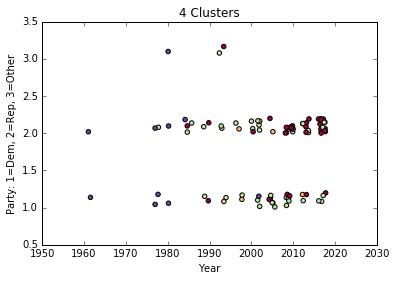

year_num
          nunique      mean  median  count
clusters                                  
0               8  3.083333     1.0     37
1               7  0.916667     1.0     11
2              10  3.250000     2.5     39
3               6  0.916667     0.5     11
Average attributes / cluster =  7.75
party_name
          nunique       mean  median  count
clusters                                   
0               3  12.333333       8     37
1               2   3.666667       4     11
2               3  13.000000      17     39
3               3   3.666667       5     11
Average attributes / cluster =  2.75
5  Clusters


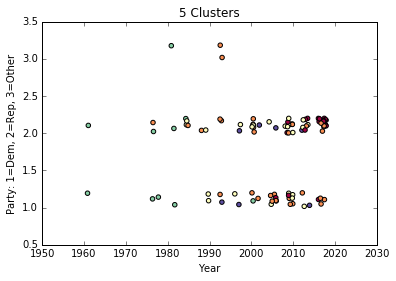

year_num
          nunique      mean  median  count
clusters                                  
0               4  1.583333     0.0     19
1               9  2.750000     1.5     33
2               8  2.250000     2.0     27
3               5  0.833333     0.0     10
4               6  0.750000     0.5      9
Average attributes / cluster =  6.4
party_name
          nunique       mean  median  count
clusters                                   
0               2   6.333333       3     19
1               3  11.000000      14     33
2               2   9.000000       8     27
3               3   3.333333       4     10
4               2   3.000000       4      9
Average attributes / cluster =  2.4
6  Clusters


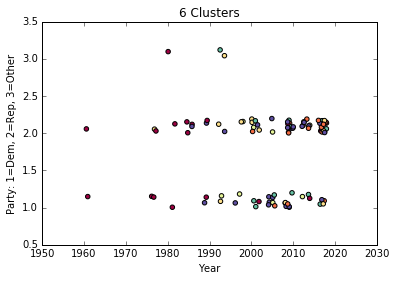

year_num
          nunique      mean  median  count
clusters                                  
0               9  1.500000     1.5     18
1               5  1.583333     0.0     19
2               6  1.166667     0.5     14
3               5  0.666667     0.0      8
4               6  1.166667     0.5     14
5               9  2.083333     1.0     25
Average attributes / cluster =  6.666666666666667
party_name
          nunique      mean  median  count
clusters                                  
0               3  6.000000       7     18
1               2  6.333333       3     19
2               3  4.666667       4     14
3               2  2.666667       4      8
4               3  4.666667       6     14
5               2  8.333333       9     25
Average attributes / cluster =  2.5
7  Clusters


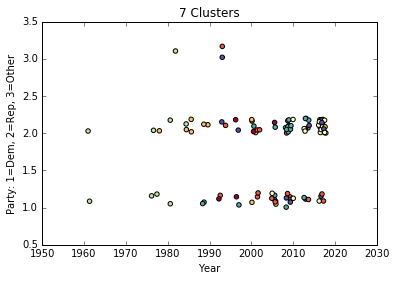

year_num
          nunique      mean  median  count
clusters                                  
0               6  0.750000     0.5      9
1               6  1.583333     0.5     19
2               6  0.916667     0.5     11
3               4  1.333333     0.0     16
4               4  0.750000     0.0      9
5               7  1.666667     1.0     20
6               6  1.166667     0.5     14
Average attributes / cluster =  5.571428571428571
party_name
          nunique      mean  median  count
clusters                                  
0               2  3.000000       4      9
1               3  6.333333       8     19
2               2  3.666667       2     11
3               2  5.333333       3     16
4               3  3.000000       4      9
5               2  6.666667       6     20
6               3  4.666667       5     14
Average attributes / cluster =  2.4285714285714284


In [230]:
# Final analysis

# Populate matrix 
var_names = ['avg_word_len','avg_word_len_no_stopword', 'lex_diversity_no_stopword']
weights = {'var':[1,1,1],'tfidf':1,'tfidf_bigrams':1}
raw_data,tf_cols,bi_tf_cols = build_data_matrix(
    cand_text_dict,var_names,word_limit=3000,bigram_limit=3000)

tf_dist = cosine
var_dist = square_dif
dist_dict = build_dist_dict(raw_data,tf_cols,bi_tf_cols,weights,var_names,tf_dist,var_dist)
distance_matrix = build_distance_matrix(raw_data,dist_dict)

# clusters are more relevant for 4-7
analyze_clusters(raw_weighted,'final',range(4,8),show_charts=True,detailed_info=True)

In [231]:
single_cand(distance_matrix,cand_text_dict)

Candidate Name REAGAN
Candidate Year 1980
Top 10 Pairs
cand_name
REAGAN_1984      0.386481
FORD_1976        0.532660
HUCKABEE_2008    0.550006
ROMNEY_2012      0.551638
GORE_2000        0.556307
THOMPSON_2008    0.556569
SANTORUM_2012    0.578027
GINGRICH_2012    0.584964
BRADLEY_2000     0.592749
MCCAIN_2008      0.597243
Name: REAGAN_1980, dtype: float64

Lowest 10 Pairs
cand_name
DEAN_2004         0.922645
LIEBERMAN_2004    0.929190
GRAHAM_2016       0.940895
RYAN_2012         0.947673
QUAYLE_1992       0.973794
DOLE_1976         0.988135
PERRY_2016        0.989823
KUCINICH_2004     1.001265
GORE_1992         1.006152
CHAFEE_2016       1.016015
REAGAN_1980            NaN
Name: REAGAN_1980, dtype: float64

Average Word Length 3.931591836734694
w/o stopwords 4.668987525384392

Lexical Diversity
0.26138671308384104 

Top 10 bigrams
years ago:  11
social security:  10
tax increase:  8
tax cut:  4
national average:  4
national security:  4
tax incentives:  4
young people:  3
economic pla

final
4  Clusters


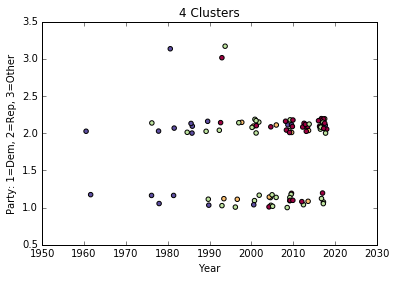

year_num
          nunique      mean  median  count
clusters                                  
0               6  2.583333     0.5     31
1               7  1.000000     1.0     12
2              10  3.166667     2.0     38
3               8  1.416667     1.5     17
Average attributes / cluster =  7.75 

party_name
          nunique       mean  median  count
clusters                                   
0               3  10.333333       6     31
1               2   4.000000       4     12
2               3  12.666667      18     38
3               3   5.666667       6     17
Average attributes / cluster =  2.75 

clusters              0  1  2  3
year_num party_name             
1960     DEM          0  0  0  1
         REP          0  0  0  1
1976     DEM          0  0  0  2
         REP          0  0  1  1
1980     DEM          0  0  0  1
         OTHER        0  0  0  1
         REP          0  0  0  1
1984     REP          0  0  1  3
1988     DEM          0  0  1  1
         REP     

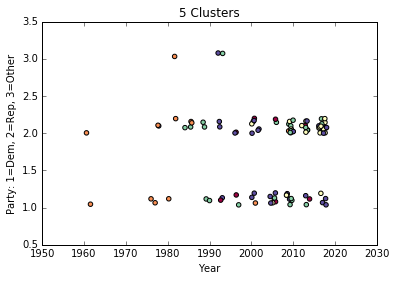

year_num
          nunique      mean  median  count
clusters                                  
0               6  0.750000     0.5      9
1               6  1.000000     0.5     12
2               5  1.666667     0.0     20
3               8  2.083333     1.5     25
4               8  2.666667     1.5     32
Average attributes / cluster =  6.6 

party_name
          nunique       mean  median  count
clusters                                   
0               2   3.000000       4      9
1               3   4.000000       5     12
2               2   6.666667       3     20
3               3   8.333333       8     25
4               3  10.666667      14     32
Average attributes / cluster =  2.6 

clusters             0  1   2  3  4
year_num party_name                
1960     DEM         0  1   0  0  0
         REP         0  1   0  0  0
1976     DEM         0  2   0  0  0
         REP         0  1   0  0  1
1980     DEM         0  1   0  0  0
         OTHER       0  1   0  0  0
       

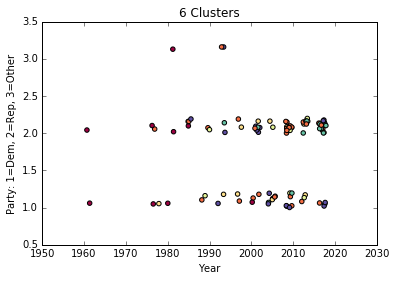

year_num
          nunique      mean  median  count
clusters                                  
0               5  0.750000     0.0      9
1              10  2.583333     2.0     31
2               8  1.000000     1.0     12
3               6  0.916667     0.5     11
4               6  1.416667     0.5     17
5               6  1.500000     0.5     18
Average attributes / cluster =  6.833333333333333 

party_name
          nunique       mean  median  count
clusters                                   
0               3   3.000000       4      9
1               3  10.333333      11     31
2               2   4.000000       5     12
3               2   3.666667       3     11
4               2   5.666667       3     17
5               3   6.000000       8     18
Average attributes / cluster =  2.5 

clusters             0  1  2  3   4  5
year_num party_name                   
1960     DEM         1  0  0  0   0  0
         REP         1  0  0  0   0  0
1976     DEM         1  0  1  0   0  0

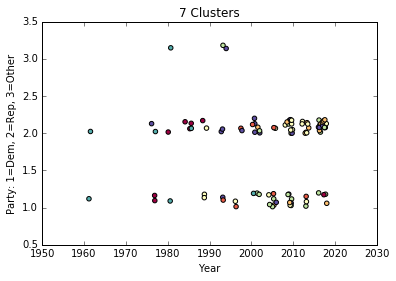

year_num
          nunique      mean  median  count
clusters                                  
0               5  0.666667     0.0      8
1               5  0.666667     0.0      8
2               5  1.583333     0.0     19
3               6  1.666667     0.5     20
4               6  1.416667     0.5     17
5               5  0.583333     0.0      7
6               7  1.583333     1.0     19
Average attributes / cluster =  5.571428571428571 

party_name
          nunique      mean  median  count
clusters                                  
0               2  2.666667       3      8
1               2  2.666667       4      8
2               2  6.333333       3     19
3               2  6.666667       6     20
4               3  5.666667       5     17
5               3  2.333333       3      7
6               3  6.333333       4     19
Average attributes / cluster =  2.4285714285714284 

clusters             0  1   2  3  4  5  6
year_num party_name                      
1960     DEM     

In [259]:
analyze_clusters(raw_weighted,'final',range(4,8),show_charts=True,detailed_info=True)

In [54]:
pairs(distance_matrix,cand_text_dict)

Candidate Name 1bush
Candidate Year 12016
Candidate Name 2bush
Candidate Year 21992

Distance:  2.11668731967 

BUSH_1992 49.0 out of  98  for  BUSH_2016
BUSH_2016 56.0 out of  98  for  BUSH_1992

BUSH_2016 

Average Word Length 3.738682614835119
w/o stopwords 4.268166901078294

Lexical Diversity
0.17252695733708392 

Top 10 bigrams
make sure:  27
next president:  17
simple fact:  17
proven record:  14
eight years:  10
federal government:  9
bell rings:  8
legal status:  8
need someone:  8
economic growth:  7
None

 BUSH_1992 

Average Word Length 3.672190160562254
w/o stopwords 4.129527991218441

Lexical Diversity
0.18688254665203075 

Top 10 bigrams
free trade:  8
go back:  7
item veto:  6
mandatory spending:  6
civil rights:  6
balanced budget:  6
tax increase:  5
one thing:  5
interest rates:  5
budget amendment:  5
None
